In [10]:
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains.retrieval import create_retrieval_chain
from langchain_google_genai import ChatGoogleGenerativeAI
import os
model = ChatGoogleGenerativeAI(
                model='gemini-2.0-flash',
                google_api_key=os.getenv('GOOGLE_API_KEY'),
                temperature=0,
                max_output_tokens=1000
            )

model.invoke('Hello')

AIMessage(content='Hello! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--6a4bea08-7387-4234-9bd2-f9c2d19eb1db-0', usage_metadata={'input_tokens': 1, 'output_tokens': 10, 'total_tokens': 11, 'input_token_details': {'cache_read': 0}})

In [6]:
import os
from langchain_google_genai import GoogleGenerativeAIEmbeddings

embeddings = GoogleGenerativeAIEmbeddings(
    model = 'models/text-embedding-004',
   google_api_key =os.getenv('GOOGLE_API_KEY')
)

embeddings


text="Hello, I am learning about embeddings!"
em = embeddings.embed_query(text)

In [3]:
from langchain_community.document_loaders import WebBaseLoader
import bs4
from langchain.text_splitter import RecursiveCharacterTextSplitter

loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()
docs

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)
all_splits

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refi

In [7]:

from langchain_community.vectorstores import FAISS
vector_store=FAISS.from_documents(
    documents=all_splits,
    embedding=embeddings
)
print(f"Vector store created with {vector_store.index.ntotal} vectors")

Vector store created with 63 vectors


In [8]:
from langchain.agents import tool
@tool()
def retrieve(query:str):
    """Retrieve the information related to the query"""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\nContent: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

In [9]:
from langchain_core.messages import SystemMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition

In [11]:
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = model.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}

tools = ToolNode([retrieve])

In [12]:
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = model.invoke(prompt)
    return {"messages": [response]}

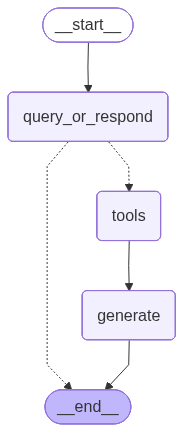

In [13]:
graph_builder = StateGraph(MessagesState)

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)
graph

In [14]:
config = {"configurable": {"thread_id": "abc123"}}
input_message="Hello"
for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

Hello! How can I help you today?


In [15]:
from langgraph.prebuilt import create_react_agent
memory = MemorySaver()
agent_executor=create_react_agent(model,[retrieve],checkpointer=memory)
config = {"configurable": {"thread_id": "def234"}}

input_message = (
    "What is the standard method for Task Decomposition?\n\n"
    "Once you get the answer, look up common extensions of that method."
)

for event in agent_executor.stream({"messages": [{"role": "user", "content": input_message}]},
                                   stream_mode="values",
                                   config=config):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the standard method for Task Decomposition?

Once you get the answer, look up common extensions of that method.
================================== Ai Message ==================================
Tool Calls:
  retrieve (2bfd8f98-6820-488d-bca0-eddcf6605429)
 Call ID: 2bfd8f98-6820-488d-bca0-eddcf6605429
  Args:
    query: standard method for Task Decomposition
================================= Tool Message =================================
Name: retrieve

('Source: {\'source\': \'https://lilianweng.github.io/posts/2023-06-23-agent/\'}\nContent: are imported by that file, and so on.\\nFollow a language and framework appropriate best practice file naming convention.\\nMake sure that files contain all imports, types etc. The code should be fully functional. Make sure that code in different files are compatible with each other.\\nBefore you finish, double check that all parts of the architecture is prese

In [16]:
from __future__ import annotations
from typing import TypedDict, List, Optional
import time

# ---- LangGraph / LangChain ----
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

from langchain_core.documents import Document
from langchain.embeddings import HuggingFaceEmbeddings

# ---- FAISS vector stores ----
import faiss
from langchain_community.vectorstores import FAISS
from langchain_community.docstore.in_memory import InMemoryDocstore

In [17]:
# ================= CONFIG =================
EMBED_MODEL = "sentence-transformers/all-MiniLM-L6-v2"  # 384-dim
VECTOR_DIM = 384

LLM_MODEL = "gpt-4o-mini"
LLM_TEMPERATURE = 0

RETRIEVE_TOP_K = 4
CACHE_TOP_K = 3

CACHE_DISTANCE_THRESHOLD = 0.45

# Optional TTL for cache entries (seconds). 0 = disabled.
CACHE_TTL_SEC = 0

In [18]:
class RAGState(TypedDict):
    question: str
    normalized_question: str
    context_docs: List[Document]
    answer: Optional[str]
    citations: List[str]
    cache_hit: bool

In [19]:
qa_index = faiss.IndexFlatL2(VECTOR_DIM)  # distance; lower is better
QA_CACHE = FAISS(
    embedding_function=embeddings,
    index=qa_index,
    docstore=InMemoryDocstore({}),
    index_to_docstore_id={}
)

In [21]:
RAG_STORE = FAISS.from_texts(
    texts=[
        "LangGraph lets you compose stateful LLM workflows as graphs.",
        "In LangGraph, nodes can be cached; node caching memoizes outputs keyed by inputs for a TTL.",
        "Retrieval-Augmented Generation (RAG) retrieves external context and injects it into prompts.",
        "Semantic caching reuses prior answers when new questions are semantically similar."
    ],
    embedding=embeddings,
)

In [22]:
def normalize_query(state: RAGState) -> RAGState:
    q = (state["question"] or "").strip()
    state["normalized_question"] = q.lower()
    return state

def semantic_cache_lookup(state: RAGState) -> RAGState:
    q = state["normalized_question"]
    state["cache_hit"] = False  # default

    if not q:
        return state

    # ✅ Guard: FAISS crashes if ntotal == 0 and you ask for k>0
    if getattr(QA_CACHE, "index", None) is None or QA_CACHE.index.ntotal == 0:
        return state

    # For FAISS L2 wrapper, this returns (Document, distance) with lower=better
    hits = QA_CACHE.similarity_search_with_score(q, k=CACHE_TOP_K)
    if not hits:
        return state

    best_doc, dist = hits[0]

    # Optional TTL
    if CACHE_TTL_SEC > 0:
        ts = best_doc.metadata.get("ts")
        if ts is None or (time.time() - float(ts)) > CACHE_TTL_SEC:
            return state

    # L2 distance gate (lower = more similar)
    if dist <= CACHE_DISTANCE_THRESHOLD:
        cached_answer = best_doc.metadata.get("answer")
        if cached_answer:
            state["answer"] = cached_answer
            state["citations"] = ["(cache)"]
            state["cache_hit"] = True

    return state

def respond_from_cache(state: RAGState) -> RAGState:
    return state

def retrieve(state: RAGState) -> RAGState:
    q = state["normalized_question"]
    docs = RAG_STORE.similarity_search(q, k=RETRIEVE_TOP_K)
    state["context_docs"] = docs
    return state

def generate(state: RAGState) -> RAGState:
    q = state["question"]
    docs = state.get("context_docs", [])
    ctx = "\n\n".join([f"[doc-{i}] {d.page_content}" for i, d in enumerate(docs, start=1)])

    system = (
        "You are a precise RAG assistant. Use the context when helpful. "
        "Cite with [doc-i] markers if you use a fact from the context."
    )
    user = f"Question: {q}\n\nContext:\n{ctx}\n\nWrite a concise answer with citations."

    resp = model.invoke([{"role": "system", "content": system},
                       {"role": "user", "content": user}])
    state["answer"] = resp.content
    state["citations"] = [f"[doc-{i}]" for i in range(1, len(docs) + 1)]
    return state

def cache_write(state: RAGState) -> RAGState:
    q = state["normalized_question"]
    a = state.get("answer")
    if not q or not a:
        return state

    QA_CACHE.add_texts(
        texts=[q],
        metadatas=[{
            "answer": a,
            "ts": time.time(),
        }]
    )
    return state

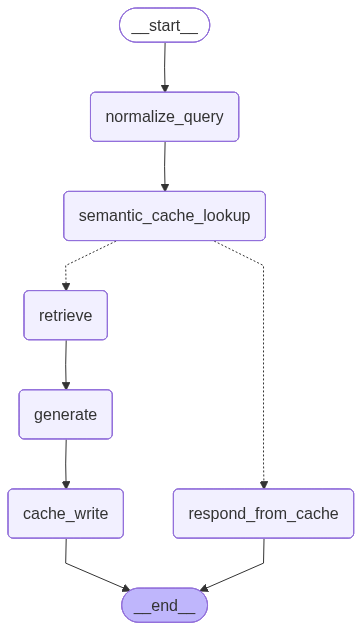

In [23]:
graph = StateGraph(RAGState)

graph.add_node("normalize_query", normalize_query)
graph.add_node("semantic_cache_lookup", semantic_cache_lookup)
graph.add_node("respond_from_cache", respond_from_cache)
graph.add_node("retrieve", retrieve)
graph.add_node("generate", generate)
graph.add_node("cache_write", cache_write)

graph.set_entry_point("normalize_query")
graph.add_edge("normalize_query", "semantic_cache_lookup")

def _branch(state: RAGState) -> str:
    return "respond_from_cache" if state.get("cache_hit") else "retrieve"

graph.add_conditional_edges(
    "semantic_cache_lookup",
    _branch,
    {
        "respond_from_cache": "respond_from_cache",
        "retrieve": "retrieve"
    }
)

graph.add_edge("respond_from_cache", END)
graph.add_edge("retrieve", "generate")
graph.add_edge("generate", "cache_write")
graph.add_edge("cache_write", END)

memory = MemorySaver()
app = graph.compile(checkpointer=memory)
app